In [563]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [564]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [598]:
from src.config import Config
from src.simba.simba import Simba
from src.simba.preprocessing_simba import PreprocessingSimba
from src.simba.plotting import Plotting

* In this notebook, we load spectra from a mgf file and this is run on SIMBA to produce the corresponding edit distance and mces distances

In [566]:
config=Config()

In [618]:
model_location= '/Users/sebas/projects/data/best_model_generated_data_20250130.ckpt'

mgf_file = '/Users/sebas/projects/data/ALL_GNPS_NO_PROPOGATED_wb.mgf'
casmi_file= '/Users/sebas/projects/data/processed_massformer/spec_df.pkl' 

## Initialize Simba

In [619]:
simba= Simba(model_location, config=config)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## load mgf file

In [620]:
all_spectrums=PreprocessingSimba.load_spectra(mgf_file, config)

  0%|                                                                                                                                                                | 62105/100000000 [00:49<22:14:34, 1248.06it/s]


We reached the end of the array at index 62105


In [621]:
len(all_spectrums)

53643

In [622]:
np.random.seed(42)
random_indexes= np.random.randint(0,len(all_spectrums),30)

In [623]:
## spectrums of the first index
import copy
N=10
all_spectrums_0 = copy.deepcopy([all_spectrums[index] for index in random_indexes])
all_spectrums_1 = copy.deepcopy([all_spectrums[index] for index in random_indexes])

In [624]:
len(all_spectrums_0)

30

## Predictions

In [625]:
sim_ed, sim_mces= simba.predict(all_spectrums_0, all_spectrums_1)

Preprocessing all the data ...


30it [00:00, 51909.70it/s]


Finished preprocessing 
loading data
Normalizing intensities
Preprocessing all the data ...


30it [00:00, 55948.92it/s]
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finished preprocessing 
loading data
Normalizing intensities


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_precursor = torch.tensor(kwargs["precursor_mass"].float())
/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  charge_precursor = torch.tensor(kwargs["precursor_charge"].float())
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

30it [00:00, 4798.43it/s]


## Ground truth

In [626]:
from src.simba.ground_truth import GroundTruth

In [627]:
ground_truth_ed=GroundTruth.compute_edit_distance(all_spectrums_0, all_spectrums_1)

In [628]:
ground_truth_mces=GroundTruth.compute_mces(all_spectrums_0, all_spectrums_1)

Running myopic ...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/b6444561782e4456847a0334c4b3f97f-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/b6444561782e4456847a0334c4b3f97f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1570 COLUMNS
At line 8075 RHS
At line 9641 BOUNDS
At line 10430 ENDATA
Problem MODEL has 1565 rows, 788 columns and 4768 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0004I processed model has 788 rows, 725 columns (725 integer (72

## Comparison between predictions and ground truth

In [629]:
from scipy.stats import spearmanr

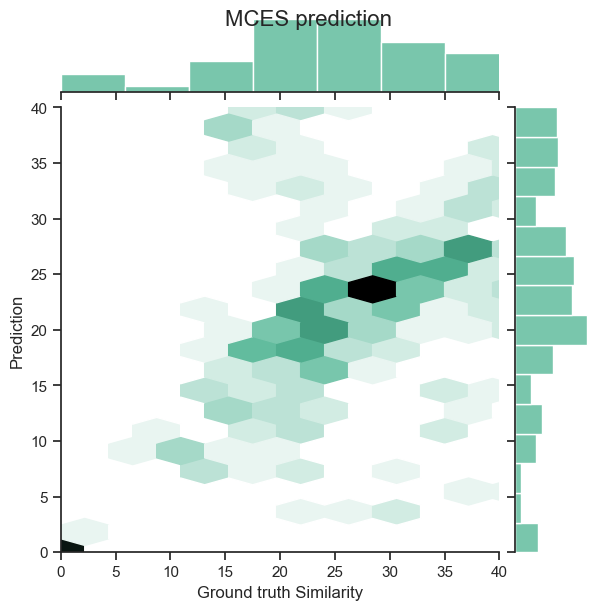

In [642]:
Plotting.plot_mces(np.reshape(ground_truth_mces,-1), np.reshape(sim_mces,-1))

Accuracy: 0.6188888888888889


/Users/sebas/projects/metabolomics/src/simba/plotting.py:26: RuntimeWarning: invalid value encountered in divide
  


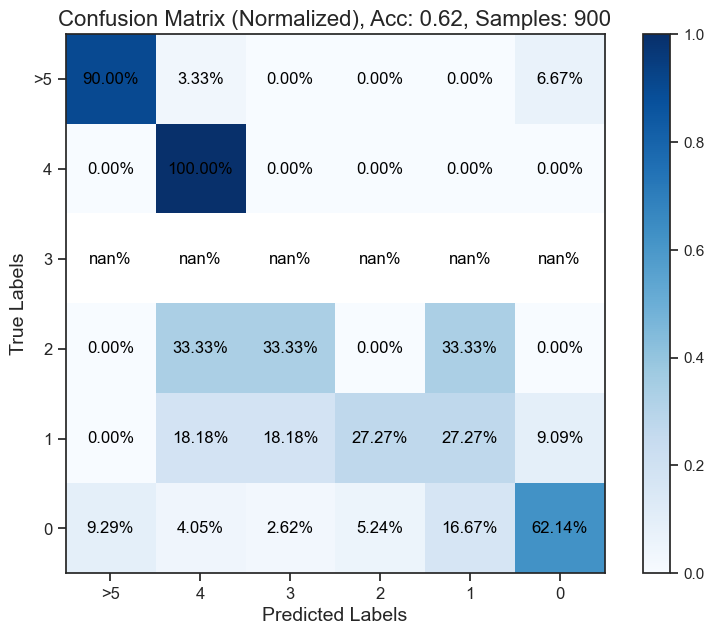

In [634]:
Plotting.plot_cm(np.reshape(ground_truth_ed,-1), np.reshape(sim_ed,-1))